#  PROYECTO NOVELLA 
 ***
 <code> **Análisis de variables relevantes** </code>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive')
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

In [3]:
# Descargamos los datos en formato parquet de Google Drive
drive.descargar_archivos_concretos('datosEntrenamiento.parquet', '../drive')

Archivo datosEntrenamiento.parquet guardado en: ../data/clean/datosEntrenamiento.parquet


In [4]:
df = pd.read_parquet('../data/clean/datosEntrenamiento.parquet')

In [6]:
df

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,GreenPerc,BelongsSaga,Price,WordsTitle,PriceFormat,...,Womens,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
0,0.0,329.0,1.0,0.51,0.40,0.44,0,19.99,1.0,paperback,...,0,0,0,0,0,0,0,0,0,0
1,0.0,269.0,2.0,0.61,0.54,0.58,1,3.99,2.0,ebook,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2335.0,1.0,0.72,0.57,0.67,1,20.99,7.0,ebook,...,0,0,0,0,1,0,0,0,0,0
3,0.0,40.0,1.0,0.83,0.35,0.73,0,25.00,1.0,hardcover,...,0,0,0,0,1,0,0,0,0,0
4,0.0,189.0,1.0,0.59,0.26,0.47,0,15.00,4.0,paperback,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,0.0,432.0,1.0,0.40,0.38,0.42,1,25.35,5.0,hardcover,...,0,0,0,0,0,0,0,0,0,0
3686,0.0,304.0,1.0,0.27,0.28,0.28,0,18.99,3.0,paperback,...,0,0,0,0,0,0,0,0,0,0
3687,0.0,160.0,1.0,0.10,0.16,0.16,0,15.39,5.0,paperback,...,0,0,0,0,0,0,0,0,0,0
3688,0.0,304.0,1.0,0.51,0.43,0.51,0,25.19,3.0,hardcover,...,0,0,0,0,0,0,0,0,0,0


### 1. Coeficientes de correlación

Para determinar qué coeficiente de correlación emplear para nuestro análisis, vamos a observar las distribuciones de nuestras variables numéricas:

In [7]:
# Variables numéricas junto con la variable respuesta
variables = ["Bestseller", "NumPages", "SagaNumber", "RedPerc", "BluePerc", "GreenPerc", 
                        "Price", "WordsTitle", 'Rating20Days', 'PrevBestSellAuthor']

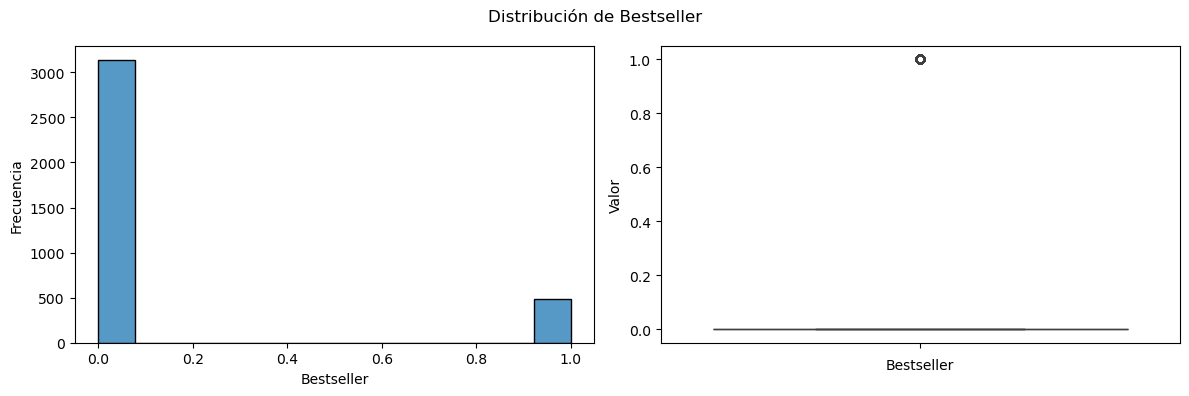

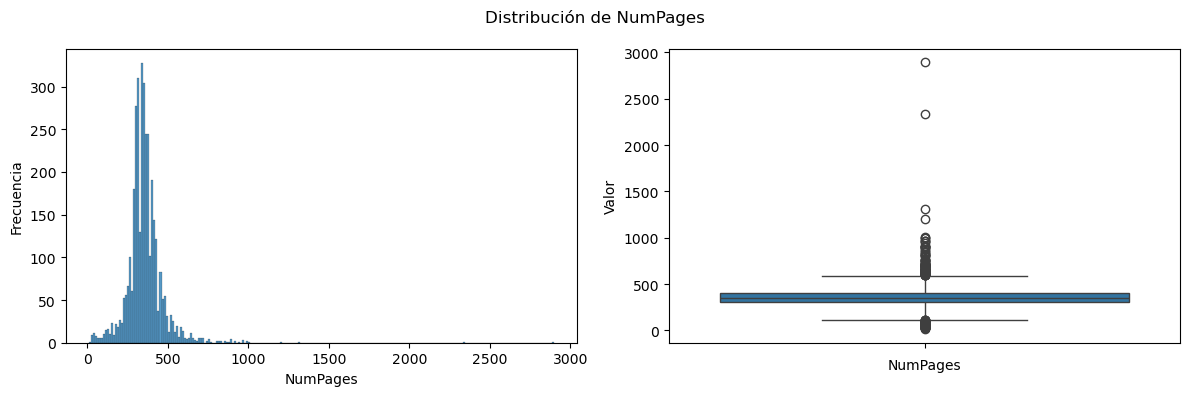

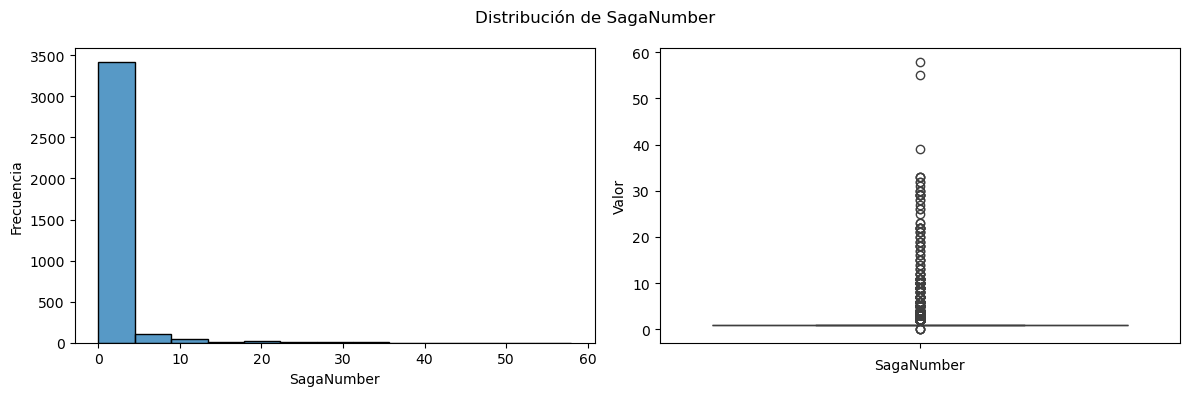

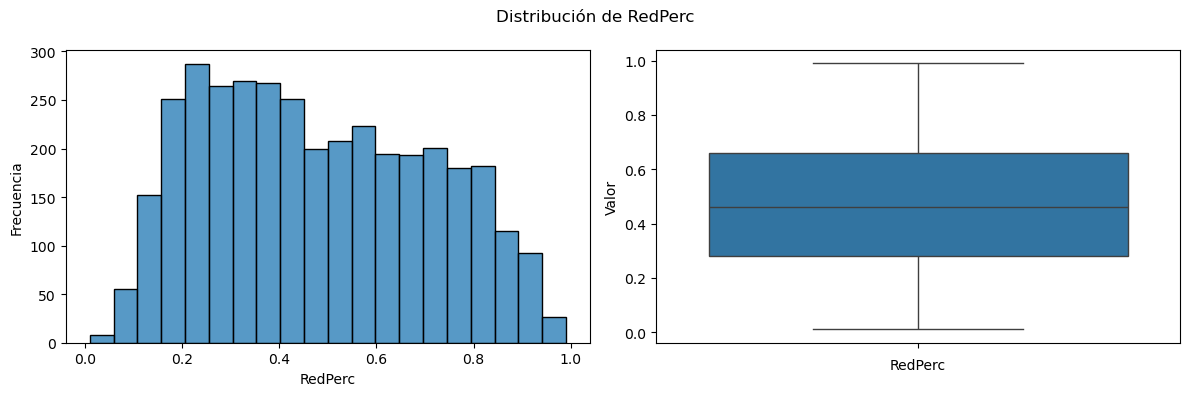

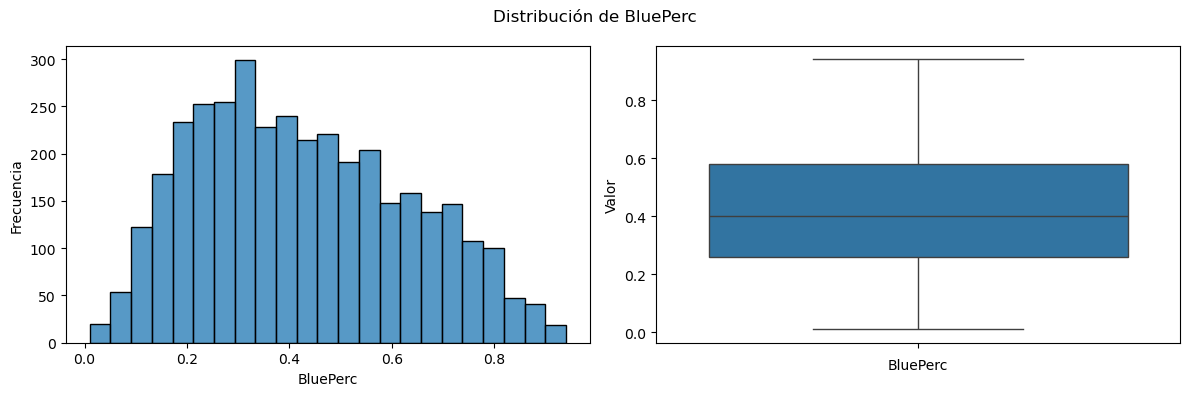

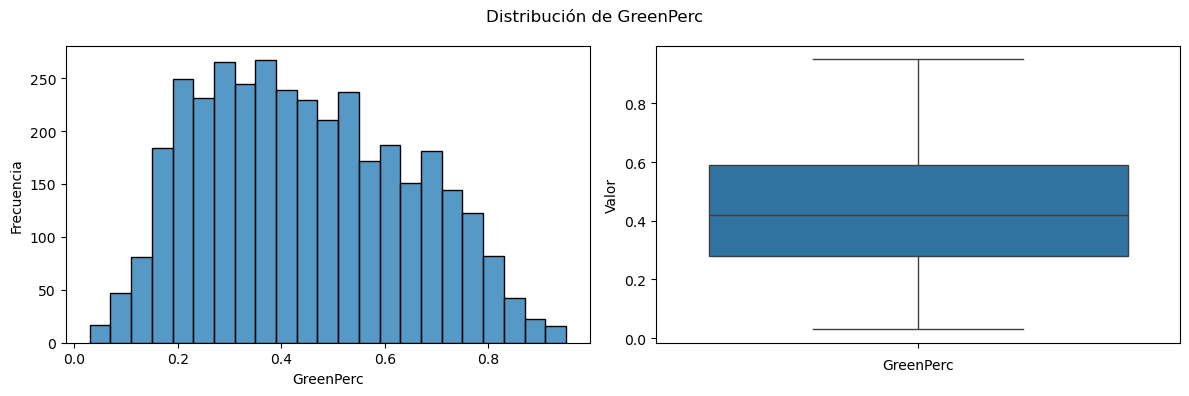

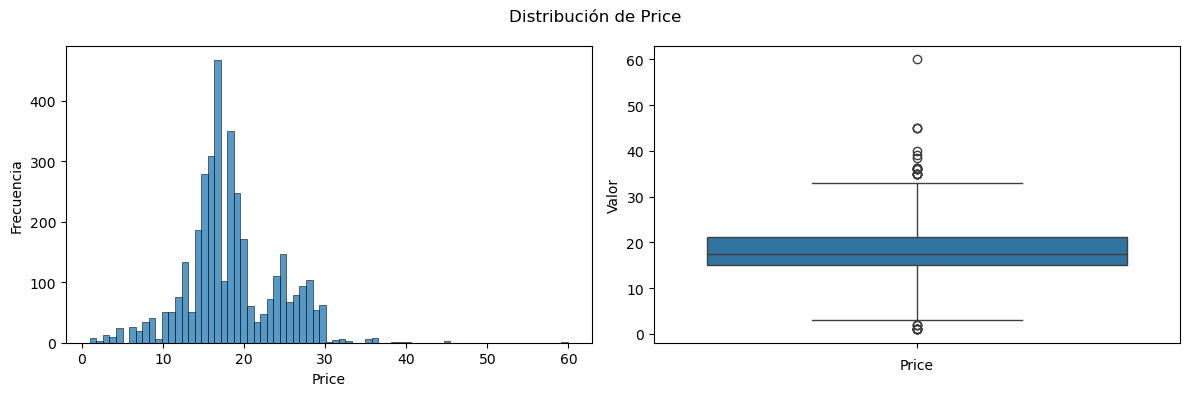

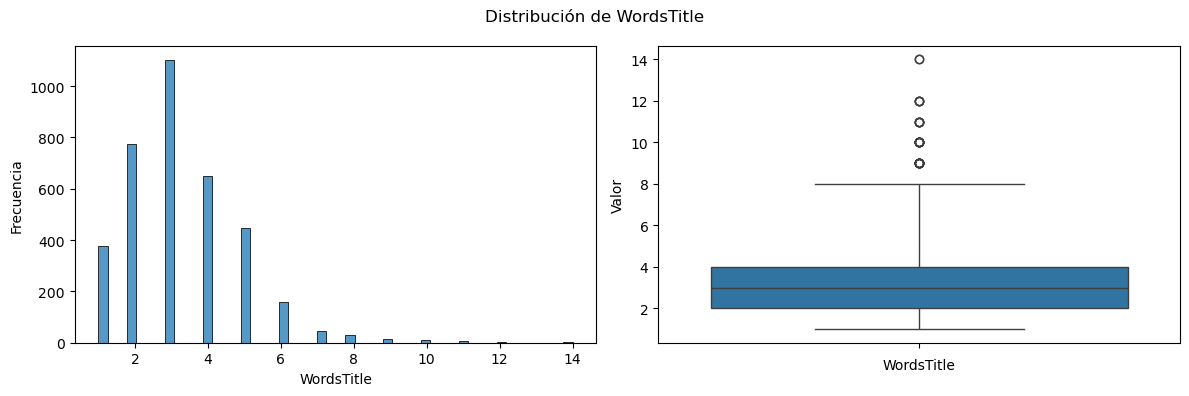

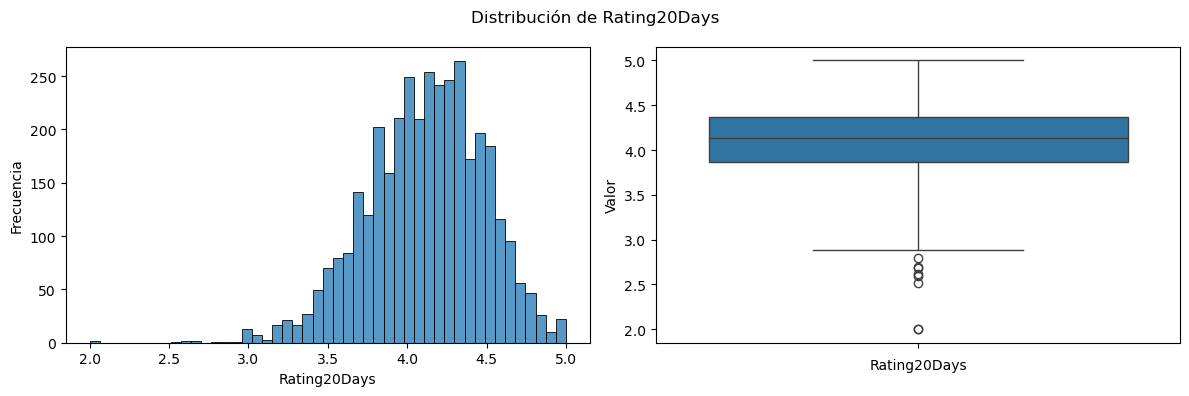

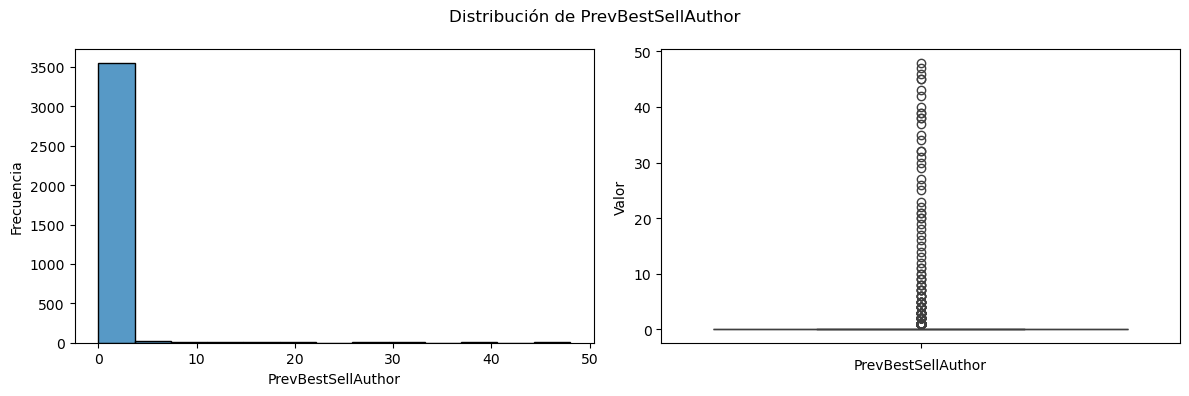

In [8]:
# Desactivamos los warnings
warnings.filterwarnings("ignore")

# Mostramos un histograma y un boxplot por cada variable
for c in df[variables]:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histograma
    sns.histplot(df[c], kde=False, ax=ax1)
    ax1.set_xlabel(c)
    ax1.set_ylabel('Frecuencia')
    
    # Boxplot
    sns.boxplot(df[c], ax=ax2, whis=2)
    ax2.set_xlabel(c)
    ax2.set_ylabel('Valor')
    
    plt.suptitle(f"Distribución de {c}")
    plt.tight_layout()  
    plt.show()

Podemos observar que por lo general son unas distribuciones sesgadas hacia la derecha, muchas de ellas muy apuntadas (NumPages, SagaNumber, Price, PrevBestSellAuthor). Quizá la variable que más se aproxime a una distribución normal sea la variable Rating20Days.

Como claramente no se satisface la condición de normalidad, pero se trata de variables continuas que se pueden transformar a rangos y disponemos de muchos datos, consideramos que el coeficiente de correlación más adecuado para nuestro estudio es el de <code>**Spearman**</code>.

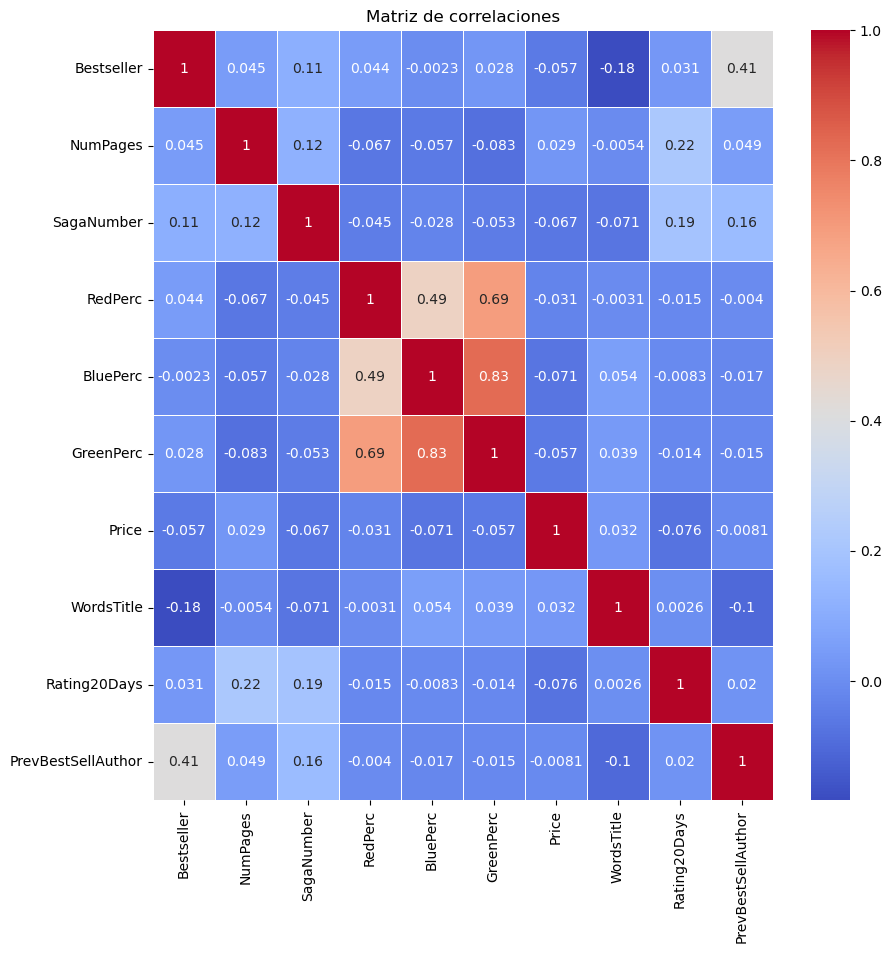

In [9]:
COEFICIENTE_CORRELACION = 'spearman'

# Calcula la matriz de correlación
correlation_matrix = df[variables].corr(method = COEFICIENTE_CORRELACION)

# Crea el mapa de calor (heatmap) usando seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlaciones')
plt.show()

Vamos a comentar los aspectos más relevantes de esta matriz de correlaciones:

- Podemos observar que en general las variables tienen poca correlación con la variable respuesta (Bestseller). Sin embargo, la que más tiene por diferencia es el número de bestsellers previos del autor, aunque está correlación no llega ni a ser moderada. 


- La variable que representa el porcentaje de pixeles verdes en la portada tiene una correlación significativa con las otras dos variables que representan el porcentaje de rojos y azules.

### 2. Información mútua

In [10]:
from sklearn.feature_selection import mutual_info_classif

# Semilla
SEED = 22

# Separamos la variable objetivo y predictores
objetivo = df[variables].columns[0]
predictores = df[variables].columns[1:]

# Calculamos la información mutua entre la variable objetivo y predictores
infoMutua = mutual_info_classif(df[predictores], df[objetivo], random_state=SEED)
infoMutua = pd.DataFrame(infoMutua, index=predictores, columns=['Información mútua'])
infoMutua.sort_values(by='Información mútua', ascending=False, inplace=True)

print(infoMutua)

                    Información mútua
PrevBestSellAuthor           0.060044
Price                        0.021384
WordsTitle                   0.017844
NumPages                     0.012854
SagaNumber                   0.012515
RedPerc                      0.006115
BluePerc                     0.006090
GreenPerc                    0.001887
Rating20Days                 0.000185


De nuevo, parece que el número previo de bestsellers de un autor es la variable que más relación parece tener con nuestra variable respuesta. Esta variable está seguida por el precio (a pesar de ser de las que peor correlación tiene con ella) y el número de palabras del título (que le sucede lo mismo).

Por otro lado, GreenPerc tiene una IM muy próxima a cero.

### 3. Test $\chi^2$

Vamos a emplear el test chi-cuadrado para determinar si hay asociación entre las variables categóricas y la variable respuesta

In [11]:
# Codificamos la variable priceFormat
df = pd.get_dummies(df, columns=['PriceFormat'], dtype=int)
df

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,GreenPerc,BelongsSaga,Price,WordsTitle,BookInterest1M,...,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies,PriceFormat_ebook,PriceFormat_hardcover,PriceFormat_paperback
0,0.0,329.0,1.0,0.51,0.40,0.44,0,19.99,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,269.0,2.0,0.61,0.54,0.58,1,3.99,2.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,2335.0,1.0,0.72,0.57,0.67,1,20.99,7.0,0.0,...,0,1,0,0,0,0,0,1,0,0
3,0.0,40.0,1.0,0.83,0.35,0.73,0,25.00,1.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,0.0,189.0,1.0,0.59,0.26,0.47,0,15.00,4.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,0.0,432.0,1.0,0.40,0.38,0.42,1,25.35,5.0,100.0,...,0,0,0,0,0,0,0,0,1,0
3686,0.0,304.0,1.0,0.27,0.28,0.28,0,18.99,3.0,103.0,...,0,0,0,0,0,0,0,0,0,1
3687,0.0,160.0,1.0,0.10,0.16,0.16,0,15.39,5.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3688,0.0,304.0,1.0,0.51,0.43,0.51,0,25.19,3.0,590.0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
from sklearn.feature_selection import chi2

variablesCategoricas = ["BelongsSaga", "HasTwitter", "HasWikipedia"] + list(df.iloc[:, 14:].columns)

# Calculamos el chi2 entre la variable objetivo y las variables predictoras categóricas
chi2_stat, p_values = chi2(df[variablesCategoricas], df[objetivo])
chi2_results_df = pd.DataFrame({'Chi2': chi2_stat, 'p-value': p_values}, index=variablesCategoricas)
chi2_results_df.sort_values(by='Chi2', ascending=False, inplace=True)

UMBRAL = 0.05
chi2_results_df

,Chi2,p-value
HasWikipedia,1.967081e+02,1.092020e-44
Detective,5.330498e+01,2.855815e-13
Classics,5.044445e+01,1.225862e-12
Crime,4.894858e+01,2.627617e-12
BelongsSaga,3.371610e+01,6.377059e-09
...,...,...
Magical Realism,1.498298e-03,9.691233e-01
Coming Of Age,1.326804e-03,9.709432e-01
Anthologies,1.079208e-03,9.737932e-01
Japanese Literature,1.074226e-04,9.917305e-01


Vamos a ver qué variables superan el test:

In [13]:
chi2_results_df[chi2_results_df["p-value"] < UMBRAL]

,Chi2,p-value
HasWikipedia,196.708085,1.092020e-44
Detective,53.304981,2.855815e-13
Classics,50.444447,1.225862e-12
Crime,48.948578,2.627617e-12
BelongsSaga,33.716104,6.377059e-09
...,...,...
Legal Thriller,4.394827,3.604811e-02
Young Adult Romance,4.243703,3.939615e-02
Mythology,4.106515,4.271831e-02
Africa,4.099248,4.290230e-02


In [14]:
list(chi2_results_df[chi2_results_df["p-value"] < UMBRAL].index)

['HasWikipedia',
 'Detective',
 'Classics',
 'Crime',
 'BelongsSaga',
 'Adventure',
 'Book Club',
 'Childrens',
 'Literature',
 'Spy Thriller',
 'Superheroes',
 'Dogs',
 'LGBT',
 'Science Fiction Fantasy',
 'Romance',
 'Contemporary',
 'Queer',
 'Contemporary Romance',
 'School',
 'Action',
 'Fantasy Romance',
 'Audiobook',
 'Polish Literature',
 'Russian Literature',
 'Botswana',
 'Military Science Fiction',
 'Realistic Fiction',
 'Horror',
 'Retellings',
 'Middle Grade',
 'Adult Fiction',
 'Gothic',
 'BDSM',
 'Westerns',
 'Military Fiction',
 'Adult',
 'Teen',
 'HasTwitter',
 'Post Apocalyptic',
 'PriceFormat_ebook',
 'Science Fiction',
 'Epic',
 'Plays',
 'Medieval',
 'Lesbian',
 'Chess',
 'Environment',
 'Classic Literature',
 'Horses',
 'Biography Memoir',
 'Banned Books',
 'Nursery Rhymes',
 'Parenting',
 'Star Wars',
 'Storytime',
 'Theatre',
 'Paranormal Romance',
 'Novella',
 'High Fantasy',
 'PriceFormat_paperback',
 'Abuse',
 'Russia',
 'Aliens',
 'Family',
 'Space Opera',
 

Podemos ver que superan el test un total de 77 variables categóricas. La que parece tener una asociación más fuerte es HasWikipedia (estadístico mayor), junto con géneros como Crime o Adventure. Además de géneros, otra variable que guarda asociación con la variable respuesta es por ejemplo BelongsSaga.